# Task: Develop Models to Predict Log Solubility using the ESOL Dataset

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### Import and glance at data

In [2]:
esol = pd.read_csv("delaney_processed.csv")
esol.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [3]:
esol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Compound ID                                      1128 non-null   object 
 1   ESOL predicted log solubility in mols per litre  1128 non-null   float64
 2   Minimum Degree                                   1128 non-null   int64  
 3   Molecular Weight                                 1128 non-null   float64
 4   Number of H-Bond Donors                          1128 non-null   int64  
 5   Number of Rings                                  1128 non-null   int64  
 6   Number of Rotatable Bonds                        1128 non-null   int64  
 7   Polar Surface Area                               1128 non-null   float64
 8   measured log solubility in mols per litre        1128 non-null   float64
 9   smiles                        

### Calculate RDkit descriptors

In [4]:
# function to calculate molecular descriptors
def RDkit_descriptors(smiles):
    # convert smiles into their corresponding molecular graphs
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    
    # calculate all descriptors available in RDkit and save to variable
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
        
    return Mol_descriptors,desc_names 

In [5]:
# function call
Mol_descriptors, desc_names = RDkit_descriptors(esol['smiles'])

# put descriptors and descriptor names into dataframe
esol_desc = pd.DataFrame(Mol_descriptors,columns=desc_names)
esol_desc.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.069684,-5.122500,10.069684,0.911295,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,0,0
1,12.547837,-2.999280,12.547837,0.099444,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,0
2,11.071016,-3.884051,11.071016,1.707414,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,0
3,8.745488,-0.641794,8.745488,0.260568,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,0
4,6.980324,-0.134259,6.980324,0.004630,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
esol_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Columns: 208 entries, MaxEStateIndex to fr_urea
dtypes: float64(104), int64(104)
memory usage: 1.8 MB


In [ ]:
#esol_desc['measured log solubility in mols per litre'] = esol[['measured log solubility in mols per litre']]
#esol_desc.dropna(inplace=True)

### Train/validation/test data split

In [7]:
np.random.seed(23) # random state

In [8]:
# define splitting function since this needs to be used more than once
def train_valid_test_split(X, y, train_ratio, test_ratio):
    test_ratio = test_ratio / (1 - train_ratio) # calc test/valid_and_test ratio
    
    # split data into training set and everything else
    X_train, X_valid_and_test, y_train, y_valid_and_test = train_test_split(X, y, train_size=train_ratio)

    # split everything else into validation and test sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_valid_and_test, y_valid_and_test, test_size=test_ratio)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test


# define function to print the ratio of the sets
def print_ratio(train_set, valid_set, test_set, total_data):
    
    train_ratio = round(train_set.size/total_data.size, 2)
    valid_ratio = round(valid_set.size/total_data.size, 2)
    test_ratio = round(test_set.size/total_data.size, 2)
    
    print(train_ratio, ":", valid_ratio, ":", test_ratio) # 0.8/0.1/0.1

In [11]:
# split data into features and labels

X_esol = esol[['Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']]
targets = esol[['measured log solubility in mols per litre']]

#X_desc = esol_desc.drop(columns=['measured log solubility in mols per litre'])
#targets_desc = esol_desc[['measured log solubility in mols per litre']]

# split ESOL data into train/valid/test sets
X_train_esol, y_train_esol, X_valid_esol, y_valid_esol, X_test_esol, y_test_esol = train_valid_test_split(X_esol, targets_esol, 0.8, 0.1)

# split RDkit descriptors into train/valid/test sets
X_train_desc, y_train_desc, X_valid_desc, y_valid_desc, X_test_desc, y_test_desc = train_valid_test_split(esol_desc, targets, 0.8, 0.1)


# print ratio of the sets
print("esol train/valid/test ratios: ", end=" ")
print_ratio(X_train_esol, X_valid_esol, X_test_esol, X_esol)
print("desc train/valid/test ratios: ", end=" ")
print_ratio(X_train_desc, X_valid_desc, X_test_desc, esol_desc)

esol train/valid/test ratios:  0.8 : 0.1 : 0.1
desc train/valid/test ratios:  0.8 : 0.1 : 0.1


### Data processing

In [12]:
# transform features from ESOL data - see HW2b
esol_feature_pipeline = make_pipeline(FunctionTransformer(np.cbrt), StandardScaler())

# transform RDkit descriptors ? ? ? ?
#desc_feature_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())

### Regression Models

#### Model1: Linear Regression Model trained on ESOL Data

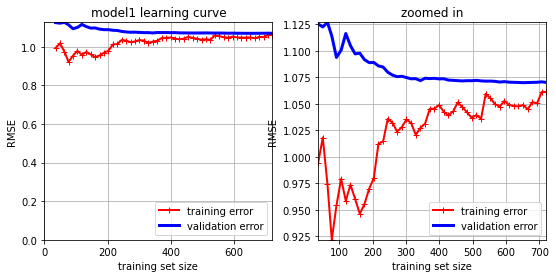

In [13]:
# train and evaluate model
model1 = make_pipeline(esol_feature_pipeline, LinearRegression())
model1.fit(X_train_esol, y_train_esol)

train_sizes, train_scores, valid_scores = learning_curve(
    model1, X_train_esol, y_train_esol, 
    train_sizes=np.linspace(0.05, 1.0, 50), 
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)


# plot the learning curve for the training set
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=False)

axs[0].grid()
axs[0].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[0].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[0].set_xlabel("training set size")
axs[0].set_ylabel("RMSE")
axs[0].legend(loc="lower right")
axs[0].set_title("model1 learning curve")
axs[0].axis([0, train_sizes.max(), 0, valid_errors.max()])

axs[1].grid()
axs[1].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[1].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[1].set_xlabel("training set size")
axs[1].set_ylabel("RMSE")
axs[1].legend(loc="lower right")
axs[1].set_title("zoomed in")
axs[1].axis([train_sizes.min(), train_sizes.max(), train_errors.min(), valid_errors.max()])

plt.show()

Overall, the model seems to be a good fit for the data. There is evidence of overfitting when training sets of under ~200 instances and escpecially when the set contains exactly 100 instances for some reason. Once the error begins to level out, there is slight evidence of the model overfitting the training set. The training error increases until 200 instances when it reaches an RMSE of 1.10, and then drops slightly but erratically to an RMSE of ~1.04 at about 500 instances and than increases again. After the size of the training set increases past 500, the training error rises slightly and seems to still show a positive slope when the full size of the training set is reached. It is possible that the model may fit the data better if more instances are added to the training set.The validation error starts out high but drops sharply to ~1.07, where it begins levels out. The slight gap between the plateaus of the training and validation error indicate slight overfitting on the training set, however, since the size of the gap is relatively small and training error is a bit erratic, the nothing drastic should be concluded. Additionally, since the error for both training and validation do not deviate much overall from between 1.00 and 1.20, model is underfitting.

In [29]:
# compare to performance on validation and test sets
model1_pred_validset = model1.predict(X_valid_esol)
model1_pred_testset = model1.predict(X_test_esol)

model1_rmse_validset = mean_squared_error(y_valid_esol, model1_pred_validset, squared=False)
model1_rmse_testset = mean_squared_error(y_test_esol, model1_pred_testset, squared=False)

print("valid set RMSE:", model1_rmse_validset)
print("test set RMSE:", model1_rmse_testset)

valid set RMSE: 1.0759970488456307
test set RMSE: 1.093737708390814


The performance is about what we expect about roughly the same as the validation error from the learning curve. Since the model seems to slightly underfit the training data, this may be the best the base linear regression model can do with the provided training data.

#### Model2: Random Forest Regression Model trained on ESOL Data

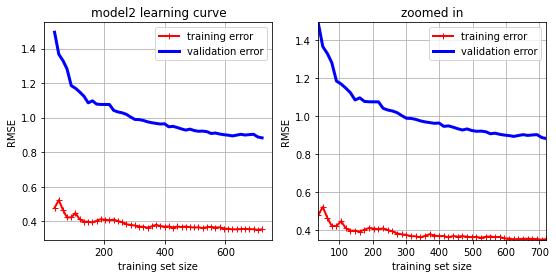

In [15]:
# train and evaluate model
model2 = make_pipeline(esol_feature_pipeline, RandomForestRegressor())
model2.fit(X_train_esol, y_train_esol.values.ravel())

train_sizes, train_scores, valid_scores = learning_curve(
    model2, X_train_esol, y_train_esol.values.ravel(), 
    train_sizes=np.linspace(0.05, 1.0, 50), 
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)


# plot the learning curve for the training set
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=False)

axs[0].grid()
axs[0].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[0].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[0].set_xlabel("training set size")
axs[0].set_ylabel("RMSE")
axs[0].legend(loc="upper right")
axs[0].set_title("model2 learning curve")

axs[1].grid()
axs[1].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[1].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[1].set_xlabel("training set size")
axs[1].set_ylabel("RMSE")
axs[1].legend(loc="upper right")
axs[1].set_title("zoomed in")
axs[1].axis([train_sizes.min(), train_sizes.max(), train_errors.min(), valid_errors.max()])

plt.show()

Here, the random forest regressor performs significantly better on the training set, indicating severe overfitting. The degree of overfitting does not seem to decrease much as the size to the training set increases, suggesting that this is a problem specific to the model itself. That being said, despite overfitting, this model still performs better on the validation set than model1.

In [31]:
# compare to performance on validation and test sets
model2_pred_validset = model2.predict(X_valid_esol)
model2_pred_testset = model2.predict(X_test_esol)

model2_rmse_validset = mean_squared_error(y_valid_esol, model2_pred_validset, squared=False)
model2_rmse_testset = mean_squared_error(y_test_esol, model2_pred_testset, squared=False)

print("valid set RMSE:", model2_rmse_validset)
print("test set RMSE:", model2_rmse_testset)

valid set RMSE: 0.8659804869611056
test set RMSE: 0.910865862126549


Again, the performance of the model on the validation and test sets is similar to what is shown on the learning curve. We know that the model overfits the training data, but it still performs better on the validation and test sets than the linear regression model.

#### Model3: Linear Regression Model trained on RDkit Descriptors

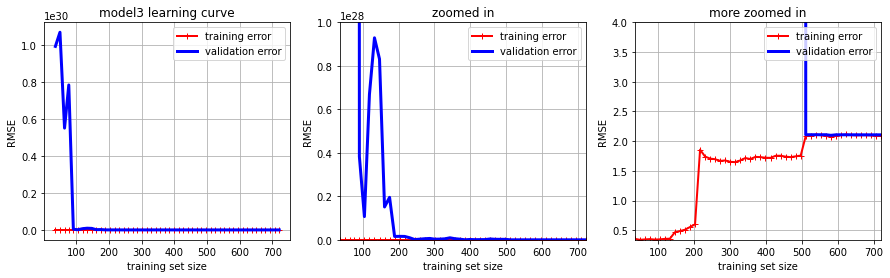

In [22]:
# train and evaluate the model
model3 = LinearRegression().fit(X_train_desc, y_train_desc)

train_sizes, train_scores, valid_scores = learning_curve(
    model3, X_train_desc, y_train_desc, 
    train_sizes=np.linspace(0.05, 1.0, 50), 
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)


# plot the learning curve for the training set
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

axs[0].grid()
axs[0].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[0].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[0].set_xlabel("training set size")
axs[0].set_ylabel("RMSE")
axs[0].legend(loc="upper right")
axs[0].set_title("model3 learning curve")

axs[1].grid()
axs[1].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[1].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[1].set_xlabel("training set size")
axs[1].set_ylabel("RMSE")
axs[1].legend(loc="upper right")
axs[1].set_title("zoomed in")
axs[1].axis([train_sizes.min(), train_sizes.max(), train_errors.min(), 1e28])

axs[2].grid()
axs[2].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[2].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[2].set_xlabel("training set size")
axs[2].set_ylabel("RMSE")
axs[2].legend(loc="upper right")
axs[2].set_title("more zoomed in")
axs[2].axis([train_sizes.min(), train_sizes.max(), train_errors.min(), 4])
plt.show()

Not entirely sure what is going on here. When the training set has under 600 instances, the model is seemingly unable to predict anything correctly for the validation set. The model is severely overfitting the training set. Perhaps I did something wrong? It is difficult to decide whether and/or how the descriptors need to be transformed since there are so many. I tested once with tranforming the descriptors, but the results were essentially the same.

In [32]:
# compare to performance on validation and test sets
model3_pred_validset = model3.predict(X_valid_desc)
model3_pred_testset = model3.predict(X_test_desc)

model3_rmse_validset = mean_squared_error(y_valid_desc, model3_pred_validset, squared=False)
model3_rmse_testset = mean_squared_error(y_test_desc, model3_pred_testset, squared=False)

print("valid set RMSE:", model3_rmse_validset)
print("test set RMSE:", model3_rmse_testset)

valid set RMSE: 2.2065638512057695
test set RMSE: 1.9981263136134653


The performance on the validation and test sets are similar to the validation error found by the learning curve for training sets with more than 500 instances. That being said, this model trained on the molecular descriptors performs significanly worse than the models trained on the esol data. 

### Model4: Lasso Linear Regression Model trained on RDkit Descriptors

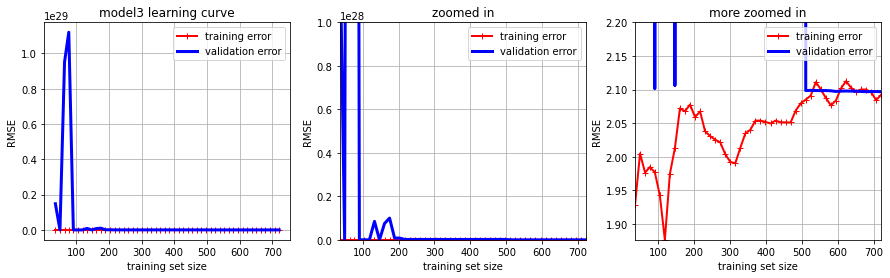

In [33]:
# train and evaluate model
model4 = LassoCV(cv=10)
model4.fit(X_train_desc, y_train_desc.values.ravel())

train_sizes, train_scores, valid_scores = learning_curve(
    model4, X_train_desc, y_train_desc.values.ravel(), 
    train_sizes=np.linspace(0.05, 1.0, 50), 
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)


# plot the learning curve for the training set
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

axs[0].grid()
axs[0].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[0].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[0].set_xlabel("training set size")
axs[0].set_ylabel("RMSE")
axs[0].legend(loc="upper right")
axs[0].set_title("model3 learning curve")

axs[1].grid()
axs[1].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[1].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[1].set_xlabel("training set size")
axs[1].set_ylabel("RMSE")
axs[1].legend(loc="upper right")
axs[1].set_title("zoomed in")
axs[1].axis([train_sizes.min(), train_sizes.max(), train_errors.min(), 1e28])

axs[2].grid()
axs[2].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[2].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[2].set_xlabel("training set size")
axs[2].set_ylabel("RMSE")
axs[2].legend(loc="upper right")
axs[2].set_title("more zoomed in")
axs[2].axis([train_sizes.min(), train_sizes.max(), train_errors.min(), 2.2])
plt.show()

Why...? Looking past the massive validation error in the beginning, even after 500 instances this model still performs worse on both the training and validation set than the models that were trained using the esol dataset. :(

In [35]:
# compare to performance on validation and test sets
model4_pred_validset = model4.predict(X_valid_desc)
model4_pred_testset = model4.predict(X_test_desc)

model4_rmse_validset = mean_squared_error(y_valid_desc, model4_pred_validset, squared=False)
model4_rmse_testset = mean_squared_error(y_test_desc, model4_pred_testset, squared=False)

print("valid set RMSE:", model4_rmse_validset)
print("test set RMSE:", model4_rmse_testset)

valid set RMSE: 2.206601239988318
test set RMSE: 1.9981040920509852


The performance varies a bit between the validation set and test set. This may be due to random splitting. The performance overall is similar to the performance of the previous model. Like the previous model, it performs worse than models 1 and 2.

### Model5: Random Forest Model trained on RDkit Descriptors

In [34]:
# hyperparam grid to search over
param_grid = {'n_estimators': [int(x) for x in np.linspace(200, 2000, 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110,  11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

model5 = RandomForestRegressor()
search = RandomizedSearchCV(model5, param_distributions=param_grid, 
                            cv=10, scoring='neg_root_mean_squared_error')

search.fit(X_train_desc, y_train_desc.values.ravel())

print("Best hyperparameters: ", search.best_params_)
print("Best score: ", -search.best_score_)

ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    X, y = self._validate_data(
  File "/Users/alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/Users/alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 899, in check_array
    _assert_all_finite(
  File "/Users/alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 146, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains infinity or a value too large for dtype('float32').


In [36]:
# train, tune, and evaluate model
model5 = RandomForestRegressor()
model5.fit(X_train_desc, y_train_desc.values.ravel())

train_sizes, train_scores, valid_scores = learning_curve(
    model5, X_train_desc, y_train_desc.values.ravel(), 
    train_sizes=np.linspace(0.05, 1.0, 50), 
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)


# plot the learning curve for the training set
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=False)

axs[0].grid()
axs[0].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[0].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[0].set_xlabel("training set size")
axs[0].set_ylabel("RMSE")
axs[0].legend(loc="upper right")
axs[0].set_title("model5 learning curve")

axs[1].grid()
axs[1].plot(train_sizes, train_errors, "r-+", linewidth=2, label="training error")
axs[1].plot(train_sizes, valid_errors, "b-", linewidth=3, label="validation error")
axs[1].set_xlabel("training set size")
axs[1].set_ylabel("RMSE")
axs[1].legend(loc="upper right")
axs[1].set_title("zoomed in")
axs[1].axis([train_sizes.min(), train_sizes.max(), train_errors.min(), valid_errors.max()])

plt.show()

ValueError: Input X contains infinity or a value too large for dtype('float32').

Could not get this to work. I guess that I'm misunderstanding something...

### Findings

The models trained on the rdkit molecular descriptors performed much worse than the models trained on the esol data. The learning curves for the models trained on descriptors were all over the place, but they all seem to have a common attribute of suddenly making better predictions for training sets larger than 500. I'm guessing that the problem with the molecular descriptors is that not all features were informative. This could be a step taken to improve all the models trained on descriptors. Since there are many many descriptors for each molecule, and each set of descriptors may have different distributions or scales, this step may take a long time.

Both models trained on the esol data performed pretty well. We can see that validation error began to plateau for model1 as we reached the full size of the training set, suggesting that the training set might not be able to perform much better than we see above. Model2 has a problem of severely overfitting the training data, but even with overfitting, it does a good job of predicting on the validation and testing set. In fact, it did the best out of all the models I tried. Looking at the learning curves for model1, we can see that both the validation and training error steadily drop as the training set size increases. The full training set is only about 700 instances, but looking at the trends, it might be worthwhile to get more data and train model2 with an even larger training set. 